In [26]:
import math, warnings
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import scipy.stats as st

In [27]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [28]:
df = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/individual_book_train/stock_0.csv")

In [29]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create liquidity, micro‑structure and realised‑volatility features."""
    # --- Level‑1 mid‑price & spread
    df["mid_price"] = (df["bid_price1"] + df["ask_price1"]) / 2
    df["spread"]    = df["ask_price1"] - df["bid_price1"]

    # --- Imbalance, book pressure and micro‑price
    with np.errstate(divide="ignore", invalid="ignore"):
        num  = df["bid_size1"] - df["ask_size1"]
        den  = df["bid_size1"] + df["ask_size1"]
        df["imbalance"] = np.where(den > 0, num / den, 0.0)

        num2 = (df["bid_size1"] + df["bid_size2"]) - (df["ask_size1"] + df["ask_size2"])
        den2 = df[["bid_size1", "bid_size2", "ask_size1", "ask_size2"]].sum(axis=1)
        df["book_pressure"] = np.where(den2 > 0, num2 / den2, 0.0)

        num3 = (df["ask_price1"] * df["bid_size1"] +
                df["bid_price1"] * df["ask_size1"])
        df["microprice"] = np.where(den > 0, num3 / den, df["mid_price"])

    # --- Normalised spread & level‑2 imbalance
    df["normalized_spread"] = df["spread"] / df["mid_price"].replace(0, np.nan)
    df["OBI_L2"] = np.where(
        den2 > 0,
        (df["bid_size1"] + df["bid_size2"]) / den2,
        0.5                                   # neutral book ‑ avoids NaNs
    )

    # --- Liquidity‑distribution entropy
    sizes  = df[["bid_size1","bid_size2","ask_size1","ask_size2"]].astype(float).values
    total  = sizes.sum(axis=1, keepdims=True)
    p      = np.divide(sizes, total, where=total != 0)
    ent    = -np.nansum(np.where(p > 0, p * np.log(p), 0.0), axis=1)
    df["LOB_entropy"]            = ent
    df["LOB_entropy_normalized"] = ent / np.log(4)

    # --- Log‑returns & 30‑tick realised‑volatility/bipower‑variance
    df["log_return"] = (
        df.groupby("time_id")["mid_price"]
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    df["realized_volatility"] = (
        df.groupby("time_id")["log_return"]
          .transform(
              lambda x: np.sqrt(
                  (x.shift(1)**2).rolling(window=30, min_periods=30).sum()
              )
          )
    )

    df["bipower_var"] = (
        df.groupby("time_id")["log_return"]
          .transform(
              lambda x: (
                  x.abs().shift(1)
                    .rolling(2, min_periods=2)
                    .apply(lambda r: r[0] * r[1], raw=True)
                    .rolling(30, min_periods=30)
                    .mean()
              )
          )
    )

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    return df

In [30]:
df = make_features(df)

In [65]:
df["rv_30_future"] = (
    df.groupby("time_id")["realized_volatility"].shift(-30)
)
df.dropna(subset=["rv_30_future"], inplace=True)

In [66]:
df = df.sort_values(["time_id", "seconds_in_bucket"])

In [67]:
feats = [
    c for c in df.columns
    if c not in {"stock_id", "time_id", "seconds_in_bucket", "rv_30_future"}
]
df_block = (
    df.groupby("time_id")
      .agg({**{c: "mean" for c in feats}, "rv_30_future": "mean"})
      .reset_index()
)

In [68]:
X = df_block[feats].values.astype(np.float32)
y = df_block["rv_30_future"].values.astype(np.float32)
time_ids = df_block["time_id"].values

In [69]:
blocks = np.unique(time_ids)
block_idx = {b: i for i, b in enumerate(blocks)}
block_indices = np.array([block_idx[t] for t in time_ids])

In [70]:
n_test_blocks = max(int(0.1 * len(blocks)), 1)
block_cv = TimeSeriesSplit(n_splits=5, test_size=n_test_blocks, gap=1)

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_rmse = float("inf")
best_state = None
best_scaler = None

In [72]:
class ANN_ARCH(nn.Module):
    def __init__(self, n_in: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),    # ← directly outputs log σ
        )

    def forward(self, x):
        return self.net(x)

In [73]:
X_tensor = torch.from_numpy(X)
y_tensor = torch.from_numpy(np.log(y))  # train in log-space

In [74]:
for fold, (train_block_idxs, val_block_idxs) in enumerate(block_cv.split(blocks), 1):
    # **Compare to block-indices**, not to time_id values:**
    train_mask = np.isin(block_indices, train_block_idxs)
    val_mask   = np.isin(block_indices, val_block_idxs)

    train_idx = np.where(train_mask)[0]
    val_idx   = np.where(val_mask)[0]

    # sanity check
    if len(val_idx) == 0:
        raise RuntimeError(f"Fold {fold} yielded 0 validation rows—check your block split.")

    # Fit scaler only on train fold
    scaler = StandardScaler().fit(X[train_idx])
    X_train = scaler.transform(X[train_idx])
    X_val   = scaler.transform(X[val_idx])

    # Wrap once as tensors
    X_train_t = torch.from_numpy(X_train).to(device)
    y_train_t = y_tensor[train_idx].to(device)
    X_val_t   = torch.from_numpy(X_val).to(device)
    y_val_t   = y_tensor[val_idx].to(device)

    train_ds = TensorDataset(X_train_t, y_train_t)
    val_ds   = TensorDataset(X_val_t,   y_val_t)
    train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=1024, shuffle=False)

    model = ANN_ARCH(n_in=X.shape[1]).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    # Train on log σ directly
    model.train()
    for epoch in range(50):
        for xb, yb in train_loader:
            opt.zero_grad()
            preds = model(xb).squeeze()
            loss = loss_fn(preds, yb)
            loss.backward()
            opt.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        preds = torch.cat([model(xb).cpu() for xb, _ in val_loader]).squeeze()
    rmse = torch.sqrt(((preds - y_val_t.cpu()) ** 2).mean())

    print(f"Fold {fold}: val RMSE (log-σ) = {rmse:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_state = model.state_dict()
        best_scaler = scaler

Fold 1: val RMSE (log-σ) = 1.4866
Fold 2: val RMSE (log-σ) = 1.3154
Fold 3: val RMSE (log-σ) = 1.3583
Fold 4: val RMSE (log-σ) = 1.3935
Fold 5: val RMSE (log-σ) = 1.1861


In [75]:
scaler_full = StandardScaler().fit(X)
X_full = scaler_full.transform(X)
X_full_t = torch.from_numpy(X_full).to(device)
y_full_t = y_tensor.to(device)

full_ds = TensorDataset(X_full_t, y_full_t)
full_loader = DataLoader(full_ds, batch_size=1024, shuffle=True)

final_model = ANN_ARCH(n_in=X.shape[1]).to(device)
final_model.load_state_dict(best_state)  # optionally warm-start
opt = torch.optim.Adam(final_model.parameters(), lr=1e-3)

In [76]:
final_model.train()
for epoch in range(50):
    for xb, yb in full_loader:
        opt.zero_grad()
        preds = final_model(xb).squeeze()
        loss = loss_fn(preds, yb)
        loss.backward()
        opt.step()

print(f"Best validation RMSE (log-σ) across folds = {best_rmse:.4f}")

Best validation RMSE (log-σ) across folds = 1.1861


In [77]:
final_model.eval()
with torch.no_grad():
    x_last = torch.from_numpy(
        scaler_full.transform(X[-1:].astype(np.float32))
    ).to(device)
    log_sigma = final_model(x_last).item()
    sigma = np.exp(log_sigma)  # convert back to σ

print(f"Forecast σ (30-tick ahead) for last time_id = {sigma:.9f}")

Forecast σ (30-tick ahead) for last time_id = 0.000508792


In [78]:
test_blocks = max(int(0.05 * len(X)), 1)
X_test  = scaler.transform(X[-test_blocks:])
y_test  = y[-test_blocks:]            


with torch.no_grad():
    X_tensor = torch.tensor(X_test).to(device)
    log_pred = model(X_tensor).cpu().numpy().ravel()
y_pred_sigma = np.exp(log_pred)        

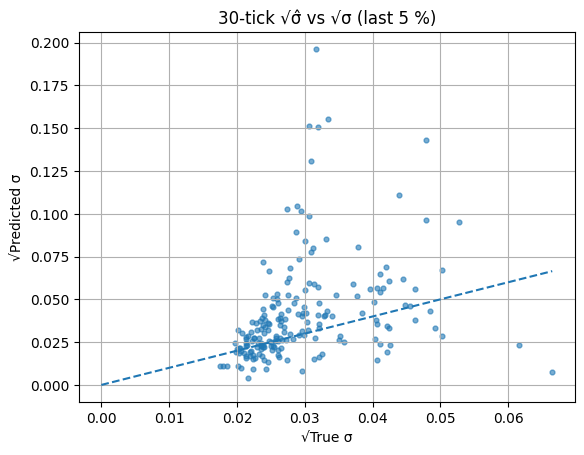

In [79]:
plt.figure()
plt.scatter(
    np.sqrt(y_test),
    np.sqrt(y_pred_sigma),
    s=12,
    alpha=0.6,
)

lims = [0, np.max(np.sqrt(y_test))]
plt.plot(lims, lims, linestyle="--")
plt.title("30-tick √σ̂ vs √σ (last 5 %)")
plt.xlabel("√True σ")
plt.ylabel("√Predicted σ")
plt.grid()
plt.show()


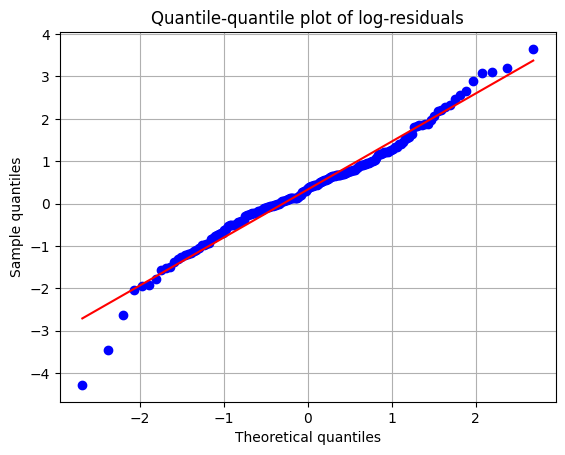

In [80]:
resid = np.log(y_pred_sigma) - np.log(y_test)
resid = resid[np.isfinite(resid)]

plt.figure()
st.probplot(resid, dist="norm", plot=plt)
plt.title("Quantile-quantile plot of log-residuals")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Sample quantiles")
plt.grid(True)
plt.show()